In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d, median_filter
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d
from scipy.special import gamma as gamma_func
from Sk import Sk as p_kp
from scipy.io import loadmat


## 1. Produce synthetic data

In [2]:
def S_hs(QD, phi):
    alpha = (1 + 2 * phi)**2 / (1 - phi)**4
    beta = -6 * phi * (1 + phi / 2)**2 / (1 - phi)**4
    gama = phi * alpha / 2
    
    G_hs = (alpha * (np.sin(QD) - QD * np.cos(QD)) / QD**2 +
            beta * (2 * QD * np.sin(QD) + (2 - QD**2) * np.cos(QD) - 2) / QD**3 +
            gama * (-QD**4 * np.cos(QD) + 4 * ((3 * QD**2 - 6) * np.cos(QD) +
            (QD**3 - 6 * QD) * np.sin(QD) + 6)) / QD**5)
    
    S = 1 / (24 * phi * G_hs/ QD + 1)
    
    return S

def S_yukawa(QD, phi, kappa, A, Q_low = 2, Q_high = 2.5):
    x = np.array([phi, kappa, A])
    Q_list = np.linspace(0, np.max(QD), 100)
    x[2] = np.log(x[2])
    x = x.reshape(1, -1)
    x = to_torch_device(x)
    q = Q_list
    S_list = f_SQ_KAN(model_KAN, x, Q=q).detach().numpy()[0]
    # Fit a quadratic function to the range Q = 2 to 2.5
    Q_fit = Q_list[(Q_list >= Q_low) & (Q_list <= Q_high)]
    S_fit = S_list[(Q_list >= Q_low) & (Q_list <= Q_high)]
    X_fit = np.vstack([Q_fit**2, np.ones(Q_fit.shape)]).T
    coefficients = np.linalg.lstsq(X_fit, S_fit, rcond=None)[0]

    # Fill Q < Q_low using the quadratic fit
    S_list[Q_list < Q_low] = coefficients[0] * Q_list[Q_list < Q_low]**2 + coefficients[1]
    f_S = interp1d(Q_list, S_list, kind='cubic')
    
    S = f_S(QD)
    
    return S

def P_hs(QD):
    P = (3*(np.sin(QD/2)-QD/2*np.cos(QD/2))/(QD/2)**3)**2
    P[QD==0] = 1    
    return P

def P_ss(QD, softness=0.2):
    P = np.exp(-QD**2/2*softness**2)*(3*(np.sin(QD/2)-QD/2*np.cos(QD/2))/(QD/2)**3)**2
    P[QD==0] = 1  
    return P

def P_fuzzy(QR, R2, sigma1, sigma2, rc):
    j1 = lambda QR: (np.sin(QR)-QR*np.cos(QR))/QR**2
    F1 = lambda QR, Qsigma: 3*j1(QR)*np.exp(-(Qsigma/2)**2)/QR
    
    QR1 = QR
    QR2 = QR*R2
    Qsigma2 = QR*sigma2
    Qsigma1 = QR*sigma1
    
    P = (rc*F1(QR1,Qsigma1)+(1-rc)*F1(QR2,Qsigma2))**2
    
    return P

# def P_star(QR, Rg):
#     P = ((1-np.exp(-QR**2*Rg**2))/(QR**2*Rg**2))**2
    
#     return P

# def p_debye(Q,Rg):
#     QRg = Q*Rg
#     u = QRg**2
#     p = 2*(np.exp(-u)+u-1)/(u**2)
#     p[QRg==0] = 1
#     return p

def P_star(Q, Rg, f):
    QRg = Q*Rg
    u = QRg
    v = u**2*f/(3*f-2)
    w = (1-np.exp(-v))
    P = 2/(f*v**2)*(v-w+(f-1)/2*w**2)
    P[QRg==0] = 1
    return P

def P_agg(Q, R, D, xi):
    QR = Q*R
    Qxi = Q*xi
    P = 1+D*gamma_func(D-1)/(QR**D*(1+1/Qxi**1)**((D-1)/2))*np.sin((D-1)*np.arctan(Qxi))*P_hs(QR)
    P[QR==0] = 1
    return P

def P_ts(Q, q_max, c):
    Qq = Q/q_max
    P = 1/((1-c)*((1-Qq**2)**2)+c)
    P[Qq==0] = 1
    return P

In [3]:
def theta_from_q(q, wavelength):
    """
    Converts q to theta (in radians), given incident wavelength.

    Parameters:
    - q : float or np.ndarray
        Scattering vector magnitude [1/Å]
    - wavelength : float
        Incident wavelength [Å]

    Returns:
    - theta : float or np.ndarray
        Scattering angle in radians
    """
    argument = q * wavelength / (4 * np.pi)
    argument = np.clip(argument, -1.0, 1.0)  # Numerical stability
    return 2 * np.arcsin(argument)

def q_from_theta(theta, wavelength):
    """
    Converts theta (in radians) to q, given incident wavelength.

    Parameters:
    - theta : float or np.ndarray
        Scattering angle in radians
    - wavelength : float
        Incident wavelength [Å]

    Returns:
    - q : float or np.ndarray
        Scattering vector magnitude [1/Å]
    """
    return (4 * np.pi / wavelength) * np.sin(theta / 2)

Example of selected wavelength and configuration

In [13]:
# Detector and experimental setup
detector_size = 1.0/2  # meters (total width of detector)
sdd = 8.0  # Sample-to-detector distance in meters
n_pixel = 256  # number of pixels across the detector from beam center to edge
pixel_size = detector_size / n_pixel

# Detector radial coordinates
d_rad = np.linspace(pixel_size, detector_size, n_pixel)

# Convert detector displacement to scattering angle
theta_rad = np.arctan2(d_rad, sdd)

# Incident wavelength
lmbda_0 = 12.0  # in Ångströms

# Convert angle to q
q_rad = q_from_theta(theta_rad, lmbda_0)  # q in Å^{-1}

# Incorent background intensity
I_inc = 1e-2

# Colloid properties
d_colloid = 500.0  # in Å
qd = q_rad * d_colloid

def f_q(q, softness=0.1, phi=0.35, I_inc=I_inc):
    """
    Returns the scattering intensity f(q) = P(q) * S(q) + I_inc.

    Parameters:
    - q : np.ndarray
        Momentum transfer values [1/Å]
    - softness : float
        Gaussian damping parameter for P(q)
    - phi : float
        Volume fraction for S(q)
    - I_inc : float
        Incoherent background intensity

    Returns:
    - f_q : np.ndarray
        Total scattering intensity at each q
    """
    P = P_ss(q, softness=softness)
    S = S_hs(q, phi=phi)
    I = P * S + I_inc
    I[~np.isfinite(I)] = 0
    return I

# prepare the ground truth data
I_gt = f_q(qd)



In [14]:
def build_resampling_matrix(d_rad, sdd, lambda_ratio_list, w_lambda, mu=0.002):
    """
    Constructs the resampling matrix R for chromatic aberration correction.

    Parameters:
    - d_rad : np.ndarray of shape (M,)
        Detector pixel displacements (radial coordinates in meters).
    - sdd : float
        Sample-to-detector distance (in meters).
    - lambda_ratio_list : np.ndarray of shape (N,)
        Ratios of λ_i / λ_0 for all wavelengths in the distribution.
    - w_lambda : np.ndarray of shape (N,)
        Normalized weights for each wavelength.
    - mu : float
        Kernel width for Gaussian radial basis interpolation (in meters).

    Returns:
    - R : np.ndarray of shape (M, M)
        Resampling matrix such that I_exp = R @ I_latent
    """
    M = len(d_rad)
    N = len(lambda_ratio_list)
    R = np.zeros((M, M))

    for i in range(N):
        ratio = lambda_ratio_list[i]
        weights = np.zeros((M, M))
        
        # Rescaled detector positions d' under λ_i
        d_rescaled = sdd * np.tan(np.arcsin(np.clip(np.sin(0.5 * np.arctan(d_rad / sdd)) * ratio, -1, 1)) * 2)
        # Gaussian RBF interpolation for each d_k → {d_j}
        for k in range(M):
            diff = d_rad - d_rescaled[k]
            phi = np.exp(-0.5 * (diff / mu) ** 2)
            phi_sum = np.sum(phi)
            if phi_sum > 0:
                phi /= phi_sum
            else:
                phi[:] = 0
                phi[k] = 1  # fallback: identity-like behavior
            weights[k, :] = phi

        R += w_lambda[i] * weights

    return R

# # Example usage:
# lambda_list = np.linspace(10.0, 14.0, 40)
# lambda_ratio = lambda_list / lmbda_0
# w_lambda = np.exp(-0.5 * ((lambda_list - lmbda_0)/0.6)**2)
# w_lambda /= np.sum(w_lambda)
# R_matrix = build_resampling_matrix(d_rad, sdd, lambda_ratio, w_lambda)

Text(0, 0.5, 'Intensity')

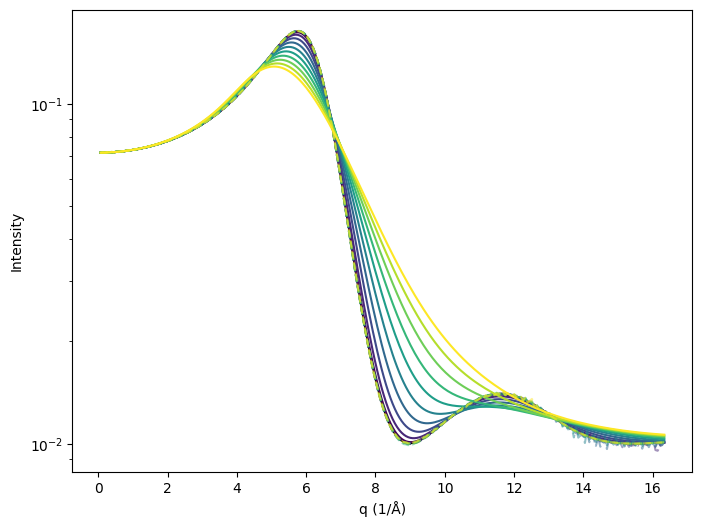

In [29]:
lambda_list = np.linspace(6.0, 18.0, 101)
lambda_ratio = lambda_list / lmbda_0
delta_lambda_list = np.linspace(0.02,0.2,10)
colors = plt.cm.viridis(np.linspace(0, 1, len(delta_lambda_list)))

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
ax.plot(qd, I_gt, label='Ground Truth', color='black', linewidth=1)

for delta_lamda in delta_lambda_list:
    w_lambda = np.exp(-0.5 * ((lambda_ratio - 1)/delta_lamda)**2)
    w_lambda /= np.sum(w_lambda)
    R_matrix = build_resampling_matrix(d_rad, sdd, lambda_ratio, w_lambda)

    # Simulate I_exp using R @ I_gt
    I_exp_simulated = R_matrix @ I_gt
    
    ax.plot(qd, I_exp_simulated, label=f'Δλ = {delta_lamda:.2f} Å', alpha=1, color = colors[int(delta_lambda_list.tolist().index(delta_lamda))])
    
    # I_pinv = np.linalg.pinv(R_matrix) @ I_exp_simulated
    # ax.plot(qd, I_pinv, '--', label=f'Pinv Δλ = {delta_lamda:.2f} Å', alpha=0.5, color = colors[int(delta_lambda_list.tolist().index(delta_lamda))])
    
    alpha = 1e-7  # or tune this based on your noise level
    R_reg = np.linalg.inv(R_matrix.T @ R_matrix + alpha * np.eye(R_matrix.shape[1])) @ R_matrix.T
    I_reg = R_reg @ I_exp_simulated
    ax.plot(qd, I_reg, '--', label=f'Pinv Δλ = {delta_lamda:.2f} Å', alpha=0.5, color = colors[int(delta_lambda_list.tolist().index(delta_lamda))])
    
ax.set_yscale('log')
ax.set_xlabel('q (1/Å)')
ax.set_ylabel('Intensity')